#Waymo Open Dataset 2D Panoramic Video Panoptic Segmentation Tutorial

- Website: https://waymo.com/open
- GitHub: https://github.com/waymo-research/waymo-open-dataset

This tutorial demonstrates how to decode and interpret the 2D panoramic video panoptic segmentation labels. Visit the [Waymo Open Dataset Website](https://waymo.com/open) to download the full dataset.

## Dataset
This dataset contains panoptic segmentation labels for a subset of the Open
Dataset camera images. In addition, we provide associations for instances between different camera images and over time, allowing for panoramic video panoptic segmentation.

For the training set, we provide tracked sequences of 5 temporal frames, spaced at t=[0ms, 400ms, 600ms, 800ms, 1200ms]. For each labeled time step, we  label all 5 cameras around the Waymo vehicle, resulting in a total of 25 labeled images per sequence. This allows for tracking over a variety of different time frames and viewpoints.

For the validation set, we label entire run segments at 5Hz (every other image), resulting in sequences of 100 temporal frames over 5 cameras (500 labels per sequence).

## Instructions
This colab will demonstrate how to read the labels, and to extract panoptic labels with consistent instance ID tracks for any number of frames.

To run, use this [colab link](https://colab.research.google.com/github/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial_maps.ipynb) to open directly in colab.

## Install Waymo Open Dataset Package


# Package Installation

In [1]:
!pip3 install waymo-open-dataset-tf-2-11-0==1.5.1

In [2]:
#@markdown ## (Optional) Install a minimal version of deeplab2 for the WOD.
# Please ignore this cell if you already have deeplab2 installed

# This shell script will download and install only those deeplab2 modules which
# are used by the WOD.
# They are used here https://github.com/waymo-research/waymo-open-dataset/blob/master/src/waymo_open_dataset/bazel/deeplab2.BUILD
!wget https://raw.githubusercontent.com/waymo-research/waymo-open-dataset/master/src/waymo_open_dataset/pip_pkg_scripts/install_deeplab2.sh -O - | bash

# Refer to the instructions on how intall the entire deeplab2 if you need other
# deeplab2 modules as well.
# https://github.com/google-research/deeplab2/blob/main/g3doc/setup/installation.md

--2023-04-10 15:26:04--  https://raw.githubusercontent.com/waymo-research/waymo-open-dataset/master/src/waymo_open_dataset/pip_pkg_scripts/install_deeplab2.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1654 (1.6K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.62K  --.-KB/s    in 0s      

2023-04-10 15:26:04 (34.6 MB/s) - written to stdout [1654/1654]

+ mkdir -p /content/deeplab2/src/deeplab2/data /content/deeplab2/src/deeplab2/evaluation
mkdir: cannot create directory ‘/content’: Permission denied
mkdir: cannot create directory ‘/content’: Permission denied


# Imports and global definitions

In [17]:
#@markdown ## Data location. Please edit.

#@markdown #### Replace this path with your own tfrecords. A tfrecord containing tf.Example protos as downloaded from the Waymo dataset webpage.
FILE_NAME = './content/waymo-open-dataset/tutorial/frames_with_maps.tfrecord' #@param {type:"string"}
#@markdown #### Replace this directory with your own dataset folder for evaluation.
EVAL_DIR = '/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/training' #@param {type: "string"}
EVAL_RUNS = ['segment-1024360143612057520_3580_000_3600_000_with_camera_labels.tfrecord','segment-11048712972908676520_545_000_565_000_with_camera_labels.tfrecord'] #@param {type: "raw"}

#@markdown #### Replace this path with the real path. Each line of the file is the "\<context_name>, \<timestamp_micros>" of a frame with camera segmentation labels.
TEST_SET_SOURCE = './content/waymo-open-dataset/tutorial/2d_pvps_validation_frames.txt' #@param {type: "string"} 

#@markdown #### Replace this directory with your own testing dataset folder.
TEST_DIR = '../../dataset/testing/' #@param {type: "string"}

#@markdown #### Replace this directory with your own local folder saving the submission.
SAVE_FOLDER = '../../result/camera_segmentation_challenge/testing/' #@param {type: "string"}



In [18]:
import os
from typing import Any, Dict, Iterator, List, Optional, Sequence, Tuple
import immutabledict
import matplotlib.pyplot as plt
import tensorflow as tf
import multiprocessing as mp
import numpy as np
import dask.dataframe as dd

if not tf.executing_eagerly():
    tf.compat.v1.enable_eager_execution()

from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset import v2
from waymo_open_dataset.protos import camera_segmentation_metrics_pb2 as metrics_pb2
from waymo_open_dataset.protos import camera_segmentation_submission_pb2 as submission_pb2
from waymo_open_dataset.wdl_limited.camera_segmentation import camera_segmentation_metrics
from waymo_open_dataset.utils import camera_segmentation_utils

# Read 2D panoptic segmentation labels from Frame proto
Note that only a subset of the frames have 2D panoptic labels.

In [19]:
dataset = tf.data.TFRecordDataset(FILE_NAME, compression_type='')
frames_with_seg = []
sequence_id = None
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    # Save frames which contain CameraSegmentationLabel messages. We assume that
    # if the first image has segmentation labels, all images in this frame will.
    if frame.images[0].camera_segmentation_label.panoptic_label:
        frames_with_seg.append(frame)
    if sequence_id is None:
        sequence_id = frame.images[0].camera_segmentation_label.sequence_id
    # Collect 3 frames for this demo. However, any number can be used in practice.
    if frame.images[0].camera_segmentation_label.sequence_id != sequence_id or len(frames_with_seg) > 2:
        break

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} ./content/waymo-open-dataset/tutorial/frames_with_maps.tfrecord; No such file or directory [Op:IteratorGetNext]

In [ ]:
# Organize the segmentation labels in order from left to right for viz later.
camera_left_to_right_order = [open_dataset.CameraName.SIDE_LEFT,
                              open_dataset.CameraName.FRONT_LEFT,
                              open_dataset.CameraName.FRONT,
                              open_dataset.CameraName.FRONT_RIGHT,
                              open_dataset.CameraName.SIDE_RIGHT]
segmentation_protos_ordered = []
for frame in frames_with_seg:
    segmentation_proto_dict = {image.name : image.camera_segmentation_label for image in frame.images}
    segmentation_protos_ordered.append([segmentation_proto_dict[name] for name in camera_left_to_right_order])
print(segmentation_protos_ordered)

# Read 2D panoptic segmentation labels from v2 components

This section aims to replicate the functionality provided above.

In [20]:
context_name = '10017090168044687777_6380_000_6400_000'
def read(tag: str, dataset_dir: str = EVAL_DIR) -> dd.DataFrame:
    """Creates a Dask DataFrame for the component specified by its tag."""
    paths = f'{dataset_dir}/{tag}/{context_name}.parquet'
    return dd.read_parquet(paths)

cam_segmentation_df = read('camera_segmentation')

# Group segmentation labels into frames by context name and timestamp.
frame_keys = ['key.segment_context_name', 'key.frame_timestamp_micros']
cam_segmentation_per_frame_df = cam_segmentation_df.groupby(
    frame_keys, group_keys=False).agg(list)

def ungroup_row(key_names: Sequence[str],
                key_values: Sequence[str],
                row: dd.DataFrame) -> Iterator[Dict[str, Any]]:
    """Splits a group of dataframes into individual dicts."""
    keys = dict(zip(key_names, key_values))
    cols, cells = list(zip(*[(col, cell) for col, cell in r.items()]))
    for values in zip(*cells):
        yield dict(zip(cols, values), **keys)

cam_segmentation_list = []
for i, (key_values, r) in enumerate(cam_segmentation_per_frame_df.iterrows()):
    # Read three sequences of 5 camera images for this demo.
    if i >=3:
        break
    # Store a segmentation label component for each camera.
    cam_segmentation_list.append(
      [v2.CameraSegmentationLabelComponent.from_dict(d) 
       for d in ungroup_row(frame_keys, key_values, r)])

In [21]:
import pandas as pd

# create a sample DataFrame
df = pd.DataFrame({
    'timestamp': pd.date_range(start='2023-04-01', end='2023-04-10', freq='D'),
    'value': range(1, 11)
})

# create a list of desired timestamps
desired_timestamps = ['2023-04-02', '2023-04-05', '2023-04-08']

# filter the rows with the desired timestamps
filtered_df = df[df['timestamp'].isin(desired_timestamps)]

print(filtered_df)

   timestamp  value
1 2023-04-02      2
4 2023-04-05      5
7 2023-04-08      8


In [22]:
# Order labels from left to right for visualization later.
# For each frame with segmentation labels, all cameras should have a label.
camera_left_to_right_order = [open_dataset.CameraName.SIDE_LEFT,
                              open_dataset.CameraName.FRONT_LEFT,
                              open_dataset.CameraName.FRONT,
                              open_dataset.CameraName.FRONT_RIGHT,
                              open_dataset.CameraName.SIDE_RIGHT]
segmentation_protos_ordered = []
for it, label_list in enumerate(cam_segmentation_list):
    segmentation_dict = {label.key.camera_name: label for label in label_list}
    segmentation_protos_ordered.append([segmentation_dict[name] for name in camera_left_to_right_order])

# Read a single panoptic label

In [23]:
# Decode a single panoptic label.
panoptic_label_front = camera_segmentation_utils.decode_single_panoptic_label_from_proto(
    segmentation_protos_ordered[0][open_dataset.CameraName.FRONT]
)

# Separate the panoptic label into semantic and instance labels.
semantic_label_front, instance_label_front = camera_segmentation_utils.decode_semantic_and_instance_labels_from_panoptic_label(
    panoptic_label_front,
    segmentation_protos_ordered[0][open_dataset.CameraName.FRONT].panoptic_label_divisor
)

# Read panoptic labels with consistent instance IDs over cameras and time

In [24]:
# The dataset provides tracking for instances between cameras and over time.
# By setting remap_to_global=True, this function will remap the instance IDs in
# each image so that instances for the same object will have the same ID between
# different cameras and over time.
segmentation_protos_flat = sum(segmentation_protos_ordered, [])
panoptic_labels, num_cameras_covered, is_tracked_masks, panoptic_label_divisor = camera_segmentation_utils.decode_multi_frame_panoptic_labels_from_segmentation_labels(
    segmentation_protos_flat, remap_to_global=True
)

# We can further separate the semantic and instance labels from the panoptic
# labels.
NUM_CAMERA_FRAMES = 5
semantic_labels_multiframe = []
instance_labels_multiframe = []
for i in range(0, len(segmentation_protos_flat), NUM_CAMERA_FRAMES):
    semantic_labels = []
    instance_labels = []
    for j in range(NUM_CAMERA_FRAMES):
        semantic_label, instance_label = camera_segmentation_utils.decode_semantic_and_instance_labels_from_panoptic_label(
            panoptic_labels[i + j], panoptic_label_divisor)
        semantic_labels.append(semantic_label)
        instance_labels.append(instance_label)
    semantic_labels_multiframe.append(semantic_labels)
    instance_labels_multiframe.append(instance_labels)
print((instance_labels_multiframe[0][1]).shape)

(1280, 1920, 1)


# Visualize the panoptic segmentation labels

In [25]:
def _pad_to_common_shape(label):
    return np.pad(label, [[1280 - label.shape[0], 0], [0, 0], [0, 0]])

# Pad labels to a common size so that they can be concatenated.
instance_labels = [[_pad_to_common_shape(label) for label in instance_labels] for instance_labels in instance_labels_multiframe]
semantic_labels = [[_pad_to_common_shape(label) for label in semantic_labels] for semantic_labels in semantic_labels_multiframe]
instance_labels = [np.concatenate(label, axis=1) for label in instance_labels]
semantic_labels = [np.concatenate(label, axis=1) for label in semantic_labels]

instance_label_concat = np.concatenate(instance_labels, axis=0)
semantic_label_concat = np.concatenate(semantic_labels, axis=0)
panoptic_label_rgb = camera_segmentation_utils.panoptic_label_to_rgb(
    semantic_label_concat, instance_label_concat)



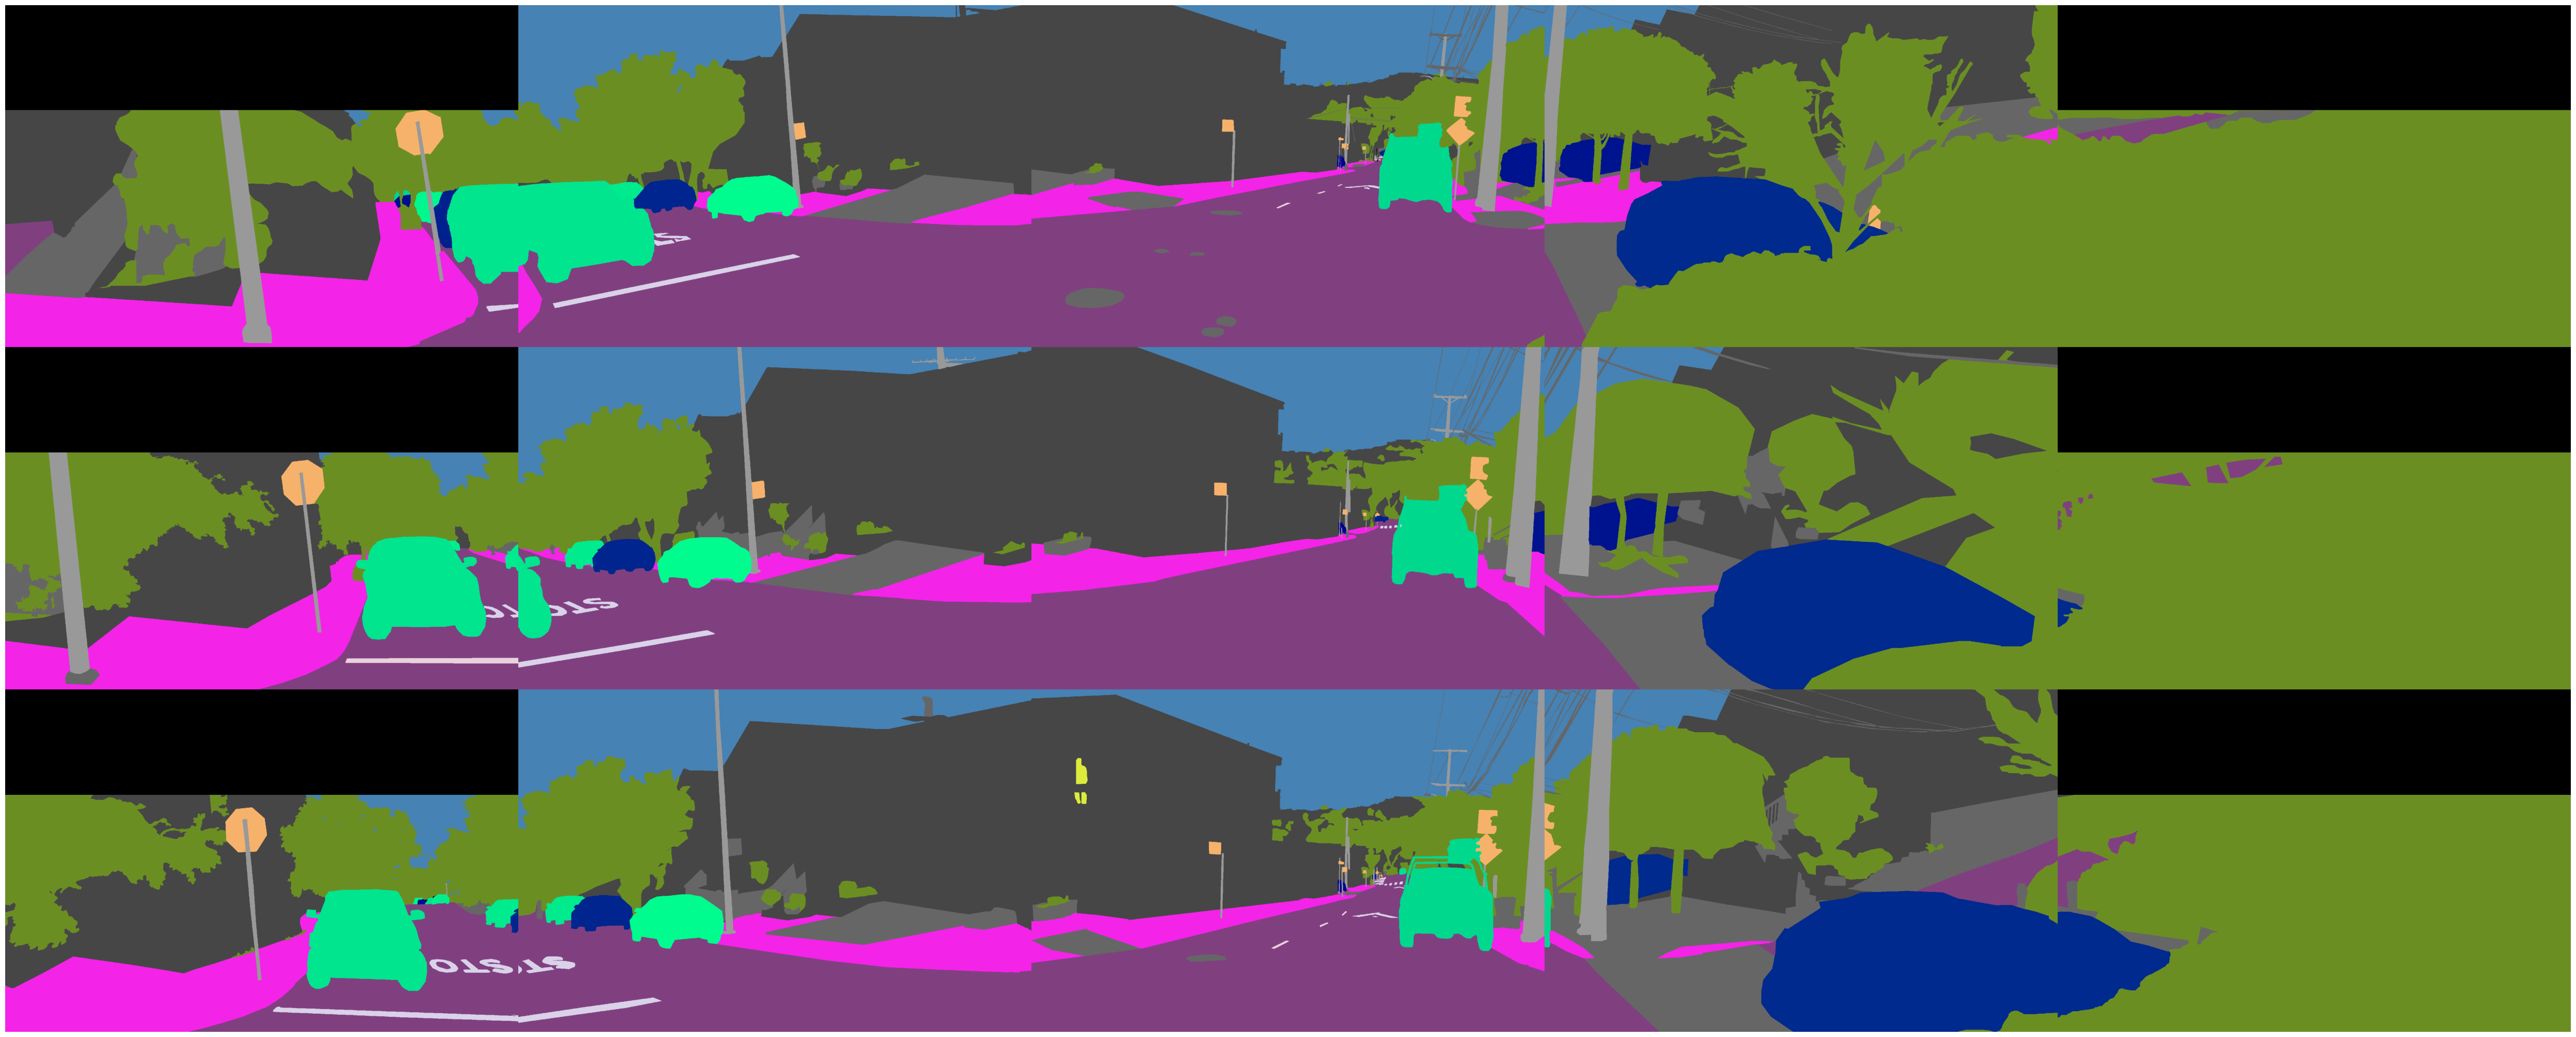

In [26]:
plt.figure(figsize=(64, 60))
plt.imshow(panoptic_label_rgb)
plt.grid(False)
plt.axis('off')
plt.show()

# Evaluate Panoptic Predictions

In [2]:
#@title Metric computation utility functions

def _run_dummy_inference_from_protos(
    image_proto_list: Sequence[bytes]
) -> List[np.ndarray]:
  """Creates dummy predictions from protos."""
  panoptic_preds = []
  for image_proto in image_proto_list:
    image_array = tf.image.decode_jpeg(image_proto).numpy()
    # Creates a dummy prediction by setting the panoptic labels to 0 for all pixels.
    panoptic_pred = np.zeros(
        (image_array.shape[0], image_array.shape[1], 1), dtype=np.int32)
    panoptic_preds.append(panoptic_pred)
  return panoptic_preds


def _compute_metric_for_dataset(filename: str):
  """Computes metric for the dataset frames."""
  eval_config = camera_segmentation_metrics.get_eval_config()
  new_panoptic_label_divisor = eval_config.panoptic_label_divisor

  dataset = tf.data.TFRecordDataset(filename, compression_type='')
  # Load first 3 frames in the demo.
  frames_with_seg, sequence_id = (
      camera_segmentation_utils.load_frames_with_labels_from_dataset(dataset, 3))

  segmentation_protos_ordered = []
  image_protos_ordered = []
  # Only aggregates frames with camera segmentation labels.
  for frame in frames_with_seg:
    segmentation_proto_dict = {image.name : image.camera_segmentation_label for image in frame.images}
    segmentation_protos_ordered.append([segmentation_proto_dict[name] for name in camera_left_to_right_order])
    image_proto_dict = {image.name: image.image for image in frame.images}
    image_protos_ordered.append([image_proto_dict[name] for name in camera_left_to_right_order])

  # The dataset provides tracking for instances between cameras and over time.
  # By setting remap_to_global=True, this function will remap the instance IDs in
  # each image so that instances for the same object will have the same ID between
  # different cameras and over time.
  segmentation_protos_flat = sum(segmentation_protos_ordered, [])
  image_protos_flat = sum(image_protos_ordered, [])
  decoded_elements = (
      camera_segmentation_utils.decode_multi_frame_panoptic_labels_from_segmentation_labels(
          segmentation_protos_flat, remap_to_global=True,
          new_panoptic_label_divisor=new_panoptic_label_divisor)
  )
  panoptic_labels, num_cameras_covered, is_tracked_masks = decoded_elements[0:3]
  
  # We provide a dummy inference function in the demo. Please replace this with 
  # your own method. It is recommended to generate your own panoptic labels first
  # and implement a function to load the generated panoptic labels from the disk.
  panoptic_preds = _run_dummy_inference_from_protos(image_protos_flat)
  return camera_segmentation_metrics.get_metric_object_by_sequence(
    true_panoptic_labels=panoptic_labels,
    pred_panoptic_labels=panoptic_preds,
    num_cameras_covered=num_cameras_covered,
    is_tracked_masks=is_tracked_masks,
    sequence_id=sequence_id,
  )

In [3]:
#@title Metric computation for a single sequence

metric_object = _compute_metric_for_dataset(FILE_NAME)
single_sequence_result = camera_segmentation_metrics.aggregate_metrics(
    [metric_object])
print('Metrics:')
print(single_sequence_result)

NameError: name 'FILE_NAME' is not defined

In [180]:
#@title Metric computation for multiple sequences (sequential)

eval_filenames = [os.path.join(EVAL_DIR, eval_run) for eval_run in EVAL_RUNS]

# For Loop version.
multi_sequence_result = camera_segmentation_metrics.aggregate_metrics(
    [_compute_metric_for_dataset(filename) for filename in eval_filenames]
)
print('Metrics:')
print(multi_sequence_result)


NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} ../../dataset/validation/segment-1024360143612057520_3580_000_3600_000_with_camera_labels.tfrecord; No such file or directory [Op:IteratorGetNext]

In [177]:
#@title Metric computation for multiple sequences (multiprocessing)

eval_filenames = [os.path.join(EVAL_DIR, eval_run) for eval_run in EVAL_RUNS]

# We provide a simple resolution to parallize the metric computation by each
# sequence through multiprocess. However, the performance varies depending on
# the machine or clusters. It is recommended to parallelize the metric
# computation as much as possible, depending on your computational resources.
with mp.Pool(processes=2) as pool:
  metric_objects = pool.imap(_compute_metric_for_dataset, eval_filenames)
  pool.close()
  pool.join()

multi_sequence_result = camera_segmentation_metrics.aggregate_metrics(
    metric_objects)
print('Metrics:')
print(multi_sequence_result)


TypeError: 'IMapIterator' object is not subscriptable

# Generate Submission

In [45]:
#@title Submission helper functions

def _make_submission_proto(
) -> submission_pb2.CameraSegmentationSubmission:
  """Makes a submission proto to store predictions for one shard."""
  submission = submission_pb2.CameraSegmentationSubmission()
  submission.account_name = 'me@gmail.com'
  submission.unique_method_name = 'My method'
  submission.authors.extend(['Author 1', 'Author 2', 'Author 3'])
  submission.affiliation = 'My institute'
  submission.description = 'Description of my method'
  submission.method_link = 'http://example.com/'
  submission.frame_dt = 1
  submission.runtime_ms = 1000
  return submission


def _load_dataset_for_one_test_shard(
    filename: str, 
    filter_by_timestamps: bool = False,
    valid_timestamps: Optional[Sequence[str]] = None,
) -> Tuple[List[open_dataset.Frame], str]:
  """Loads (subsampled) dataset frames and sequence id for evaluation."""
  dataset = tf.data.TFRecordDataset(filename, compression_type='')
  test_frames = []
  sequence_id = ''

  for index, data in enumerate(dataset):
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    
    if not sequence_id:
      sequence_id = frame.context.name
    # Skip frames if `filter_by_timestamps` is set to True and 
    # corresponding timestamp is in the `valid_timestamps` list. Otherwise, keep all the frames
    # from a test sequence in the submission.
    if filter_by_timestamps and not str(frame.timestamp_micros) in valid_timestamps:
      continue
    test_frames.append(frame)
      
  return test_frames, sequence_id


def _generate_predictions_for_one_test_shard(
    submission: submission_pb2.CameraSegmentationSubmission,
    filename: str,
    valid_timestamps: Optional[Sequence[str]] = None,
) -> None:
  """Iterate over all test frames in one sequence and generate predictions."""
  test_frames, sequence_id = _load_dataset_for_one_test_shard(
      filename,
      filter_by_timestamps=True if valid_timestamps else False,
      valid_timestamps=valid_timestamps)
  image_protos_ordered = []
  frame_timestamps_ordered = []
  camera_names_ordered = []
  print(f'Loading test sequence {sequence_id}...')
  for frame in test_frames:
    image_proto_dict = {image.name: image.image for image in frame.images}
    image_protos_ordered.append(
        [image_proto_dict[name] for name in camera_left_to_right_order])
    frame_timestamps_dict = {image.name: frame.timestamp_micros for image in frame.images}
    frame_timestamps_ordered.append(
        [frame_timestamps_dict[name] for name in camera_left_to_right_order])
    camera_names_ordered.append(
        [name for name in camera_left_to_right_order])

  print(f'Processing test sequence {sequence_id}...')
  image_protos_flat = sum(image_protos_ordered, [])
  frame_timestamps_flat = sum(frame_timestamps_ordered, [])
  camera_names_flat = sum(camera_names_ordered, [])
  # We provide a dummy inference function in the demo. Please replace this with 
  # your own method. It is recommended to generate your own panoptic labels first
  # and implement a function to load the generated panoptic labels from the disk.
  panoptic_preds = _run_dummy_inference_from_protos(image_protos_flat)
  # The `panoptic_label_divisor` must be greater than the largest number of 
  # instances in a single frame.
  panoptic_label_divisor = 1000
  for panoptic_pred, frame_timestamp, camera_name in zip(
      panoptic_preds, 
      frame_timestamps_flat, 
      camera_names_flat):
    seg_proto = camera_segmentation_utils.save_panoptic_label_to_proto(
        panoptic_pred,
        panoptic_label_divisor,
        sequence_id)
    seg_frame = metrics_pb2.CameraSegmentationFrame(
        camera_segmentation_label=seg_proto,
        context_name=sequence_id,
        frame_timestamp_micros=frame_timestamp,
        camera_name=camera_name
    )
    submission.predicted_segmentation_labels.frames.extend([seg_frame])


def _save_submission_to_file(
    submission: submission_pb2.CameraSegmentationSubmission,
    filename: str,
    save_folder: str = SAVE_FOLDER,
) -> None:
  """Save predictions for one sequence as a binary protobuf."""
  os.makedirs(save_folder, exist_ok=True)
  basename = os.path.basename(filename)
  if '.tfrecord' not in basename:
    raise ValueError('Cannot determine file path for saving submission.')
  submission_basename = basename.replace('_with_camera_labels.tfrecord',
                                         '_camera_segmentation_submission.binproto')
  submission_file_path = os.path.join(save_folder, submission_basename)
  print(f'Saving predictions to {submission_file_path}...\n')
  f = open(submission_file_path, 'wb')
  f.write(submission.SerializeToString())
  f.close()

In [46]:
#@title Generate a submission file for a single sequence

if os.path.isdir(SAVE_FOLDER):
  os.removedirs(SAVE_FOLDER)

submission = _make_submission_proto()
print('Submission proto size: ', len(submission.SerializeToString()))
# Here, we do not set the valid_timestamps assuming all the frames in a test
# sequence will be included.
# However, in the final submission please consider only include the requested
# frames to reduce the submission package size.
_generate_predictions_for_one_test_shard(submission, FILE_NAME)
print('Submission proto size: ', len(submission.SerializeToString()))
_save_submission_to_file(submission, FILE_NAME, SAVE_FOLDER)

Submission proto size:  123
Loading test sequence 11004685739714500220_2300_000_2320_000...
Processing test sequence 11004685739714500220_2300_000_2320_000...
Submission proto size:  43729


ValueError: Cannot determine file path for saving submission.

In [47]:
#@title Generate submission files for multiple sequences in the test set

if os.path.isdir(SAVE_FOLDER):
  os.removedirs(SAVE_FOLDER)

context_name_timestamp_tuples = [x.rstrip().split(',') for x in (
    tf.io.gfile.GFile(TEST_SET_SOURCE, 'r').readlines())]

context_names_dict = {}
for context_name, timestamp_micros in context_name_timestamp_tuples:
  if context_name not in context_names_dict:
    context_names_dict.update({context_name: [timestamp_micros]})
  else:
    context_names_dict[context_name].append(timestamp_micros)

# We save each test sequence in an indepedent submission file.
for context_name in context_names_dict.keys():
  test_filename = os.path.join(TEST_DIR, f'segment-{context_name}_with_camera_labels.tfrecord')
  if not tf.io.gfile.exists(test_filename):
    raise ValueError(f'Missing .tfrecord {context_name} under {TEST_DIR}.')
  submission = _make_submission_proto()
  print('Submission proto size: ', len(submission.SerializeToString()))
  # We only include frames with timestamps requested from the .txt file in 
  # the submission.
  _generate_predictions_for_one_test_shard(
      submission, 
      test_filename,
      valid_timestamps=context_names_dict[context_name])
  print('Submission proto size: ', len(submission.SerializeToString()))
  _save_submission_to_file(submission, test_filename, SAVE_FOLDER)

ValueError: Missing .tfrecord 1024360143612057520_3580_000_3600_000 under ../../dataset/testing/.

## Packaging submission files 

In [ ]:
!tar czvf /tmp/camera_segmentation_challenge/submit_testing.tar.gz -C $SAVE_FOLDER .